In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm
import ot
import os
import pickle
import copy

from geomloss import SamplesLoss

from torchmin import minimize, minimize_constr
import time

import matplotlib.animation as animation

%matplotlib inline

# Utilities

In [2]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, labels):
        super().__init__()
        self.inputs = inputs
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

def add_one_row(x):
    return torch.cat((x, torch.ones(x.shape[0]).view((x.shape[0],1))), dim=1)

def model_plot_2d(model, add_one=False, N_points=100, x_lim=(-5,5), plot=True): ## Data plot
    x = np.linspace(*x_lim, N_points)
    y = np.linspace(*x_lim, N_points)
    xx, yy = np.meshgrid(x, y)
    if add_one:
        inputs = torch.tensor(np.stack((xx.flatten(), yy.flatten(), np.ones(N_points**2))), dtype=torch.float32).T
    else:
        inputs = torch.tensor(np.stack((xx.flatten(), yy.flatten())), dtype=torch.float32).T
    zz = model(inputs).detach().view((N_points, N_points)).numpy()
    if plot:
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        surf = ax.plot_surface(xx, yy, zz, linewidth=0, antialiased=False, cmap=cm.coolwarm)
        fig.colorbar(surf)
        plt.show()
    return xx, yy, zz

def model_plot_1d(model, add_one=False, N_points=1000, x_lim=(-10,10)): ## Data plot
    x = np.linspace(*x_lim, N_points)
    if add_one:
        inputs = torch.tensor(np.stack((x, np.ones(N_points))), dtype=torch.float32).T
    else:
        inputs = torch.tensor(x, dtype=torch.float32).view((N_points, -1))
    y = model(inputs).detach().squeeze().numpy()
    plt.plot(x, y)
    plt.show()

def weight_animation_2d(weight_array, name='animation.mp4'):
    fig = plt.figure(figsize=(10, 3))
    ax = fig.add_subplot()
    
    x_min, x_max = np.min(weight_array[:,:,0])-0.2, np.max(weight_array[:,:,0])+0.2
    y_min, y_max = np.min(weight_array[:,:,1])-0.2, np.max(weight_array[:,:,1])+0.2
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('equal')
    
    points, = ax.plot([], [], 'o', c='blue', ms=3)
    def animate(i):
        points.set_data(weight_array[i,:,0], weight_array[i,:,1])
        return points
    
    time = 20
    fps = 10
    frames = time * fps
    rate = weight_array.shape[0] // frames
    anim = animation.FuncAnimation(fig, lambda i: animate(rate*i), frames, blit=False, interval=1)
    writer = animation.FFMpegWriter(fps=fps)
    anim.save(name, writer = writer)


def circle_to_line(x):
    return 2 * np.arctan( x[:,1] / (1+x[:,0]))

def gaussian_conv(x, coef=None, scale=1, interval=(-np.pi, np.pi), N_points=1000):
    res = np.zeros(N_points)
    z_min, z_max = interval
    z = np.linspace(z_min, z_max, N_points+1)
    z = 0.5*(z[1:]+z[:-1])
    if coef is None:
        coef = np.ones(len(x)) / len(x)
    for i in range(len(x)):
        res += coef[i] * np.exp(- 0.5 * (z_min + (z-x[i]-z_min) % (z_max-z_min))**2 / scale**2)
    return z, normalize(res, interval=interval)

def Laplacian(f, h=1):
    return (np.roll(f, 1) + np.roll(f, -1) - 2*f) / h**2

def Grad(f, h=1):
    return (f - np.roll(f, 1)) / h

def Laplacian_2d(f, h=1):
    return (np.roll(f, 1, axis=0) + np.roll(f, -1, axis=0) + np.roll(f, 1, axis=1) + np.roll(f, -1, axis=1) - 4*f) / h**2

def Grad_2d(f, h=1):
    grad0 = (f - np.roll(f, 1, axis=0)) / h
    grad1 = (f - np.roll(f, 1, axis=1)) / h
    return np.stack([grad0, grad1], axis=2)

def normalize(f, interval=(-np.pi,np.pi)):
    z_min, z_max = interval
    return len(f) * f / (f.sum() * (z_max-z_min))

def pmax(x, t):
    return torch.maximum(x, t*torch.ones_like(x))

def pmin(x, t):
    return torch.minimum(x, t*torch.ones_like(x))

# Training routines

In [3]:
def training_loop(model, train_loader, optimizer, criterion, noisy=False, tau=0.1):
    loss_list = []
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        loss = criterion(inputs, targets, model)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        if noisy:
            with torch.no_grad():
                for group in optimizer.param_groups:
                    for p in group["params"]:
                        p.add_(tau * torch.randn_like(p))
        if hasattr(model, 'clipper'):
            model.clipper(model)
    return loss_list

class LearningProblem():
    def __init__(self, model, train_loader, optimizer, criterion):
        super().__init__()
        self.model = model
        self.train_loader = train_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.loss_list = []
        self.state_list = [copy.deepcopy(self.model.state_dict())]

    def train(self, epochs, noisy=False, tau=0.1):
        self.model.train()
        iterator = tqdm(range(epochs))
        for i in iterator:
            loss = training_loop(self.model, self.train_loader, self.optimizer, self.criterion, noisy=noisy, tau=tau)
            self.loss_list.extend(loss)
            self.state_list.append(copy.deepcopy(self.model.state_dict()))
            iterator.set_description(f'log10(loss) = {np.log10(self.loss_list[-1]):.2f}')

# Models

In [4]:
class ActivationFunction(nn.Module):
    def __init__(self, f):
        super().__init__()
        self.f = f
        
    def forward(self, x):
        return self.f(x)

class VarProModel(nn.Module):
    def __init__(self, feature_model, width, output_dim, VarProTraining=True, clipper=None):
        super().__init__()
        self.feature_model = feature_model
        self.VarProTraining = VarProTraining
        self.width = width
        self.outer = nn.Linear(width, output_dim, bias=False)
        if VarProTraining:
            self.outer.weight.requires_grad = False
        if clipper is not None:
            self.clipper = clipper
            self.clipper(self)

    def forward(self, inputs):
        return self.outer(self.feature_model(inputs)) / self.width ## normalized output function

class SHLFeatureModel(nn.Module):
    def __init__(self, input_dim, width, activation, bias=False):
        super().__init__()
        self.weight = nn.Parameter(data=torch.randn(width, input_dim), requires_grad=True)
        self.activation = activation
        self.bias = nn.Parameter(data=torch.zeros(width), requires_grad=bias)

    def forward(self, x):
        return self.activation(nn.functional.linear(x, self.weight, self.bias))

class ConvolutionFeatureModel(nn.Module):
    def __init__(self, input_dim, width, activation, scale):
        super().__init__()
        self.weight = nn.Parameter(data=torch.randn(width, input_dim), requires_grad=True)
        self.activation = activation
        self.scale = scale

    def forward(self, x):
        return self.activation(torch.linalg.vector_norm(self.weight.T[None,:,:] - x[:,:,None], dim=1) / self.scale)

def SHL(input_dim, width, activation, bias=False, VarProTraining=True, clipper=None):
    feature_model = SHLFeatureModel(input_dim, width, activation, bias=bias)
    return VarProModel(feature_model, width, 1, VarProTraining=VarProTraining, clipper=clipper)

def Convolution(input_dim, width, activation, scale, VarProTraining=True, clipper=None):
    feature_model = ConvolutionFeatureModel(input_dim, width, activation, scale)
    return VarProModel(feature_model, width, 1, VarProTraining=VarProTraining, clipper=clipper)

def freeze(module):
    for p in module.parameters():
        p.requires_grad = False

# Criterions

In [5]:
## VarPro for quadratic loss
class ExactRidgeProjection():
    def __init__(self, lmbda, keep_alpha=False):
        self.lmbda = lmbda
        self.keep_alpha = keep_alpha
        if self.keep_alpha:
            self.alpha_list = []
    
    @torch.no_grad()
    def __call__(self, inputs, targets, model, requires_grad=False):
        features = model.feature_model(inputs).clone().detach()
        batch_size, width = features.shape[0], features.shape[1]
        if not self.keep_alpha and batch_size > width: ## underparameterized case
            K = (features.T @ features) / (batch_size * width)
            u = torch.linalg.solve(K + self.lmbda * torch.eye(width),  (features.T @ targets) / batch_size)
        else: ## overparameterized case
            K = (features @ features.T) / (batch_size*width)
            alpha = torch.linalg.solve(K + self.lmbda * torch.eye(batch_size), targets)
            u = features.T @ alpha / batch_size
            if self.keep_alpha:
                self.alpha_list.append(alpha)
        model.outer.weight = nn.Parameter(data=u.view((1,-1)), requires_grad=requires_grad)

class ExactRidgeProjectionUnbiased():
    def __init__(self, lmbda):
        self.lmbda = lmbda
    
    @torch.no_grad()
    def __call__(self, inputs, targets, model, requires_grad=False):
        features = model.feature_model(inputs).clone().detach()
        batch_size, width = features.shape[0], features.shape[1]
        K = (features.T @ features) / (batch_size * width)
        u = torch.linalg.solve(K + self.lmbda * torch.eye(width),  (features.T @ targets) / batch_size + self.lmbda)
        model.outer.weight = nn.Parameter(data=u.view((1,-1)), requires_grad=requires_grad)

class ApproximateRidgeProjection():
    def __init__(self, lmbda, method='cg', tol=1e-7):
        self.lmbda = lmbda
        self.method = method
        self.tol = tol

    def __call__(self, inputs, targets, model):
        features = model.feature_model(inputs).clone().detach()
        width = features.shape[1]
        ridge_objective = lambda u: ((features @ u / width - targets)**2).mean() + self.lmbda * (u**2).mean()
        u = minimize(ridge_objective, model.outer.weight.detach().squeeze(), method=self.method, tol=self.tol).x
        model.outer.weight = nn.Parameter(data=u.view((1,-1)), requires_grad=False)

class LeastSquareCriterion(nn.Module):
    def __init__(self, lmbda, projection=None):
        super().__init__()
        self.lmbda = lmbda
        self.projection = projection
        
    def forward(self, inputs, targets, model):
        if self.projection is not None:
            self.projection(inputs, targets, model)
        predictions = model(inputs)
        return 0.5 * ((predictions - targets)**2).mean() / self.lmbda  + 0.5 * (model.outer.weight**2).mean()

class LeastSquareCriterionUnbiased(nn.Module):
    def __init__(self, lmbda, projection=None):
        super().__init__()
        self.lmbda = lmbda
        self.projection = projection
        
    def forward(self, inputs, targets, model):
        if self.projection is not None:
            self.projection(inputs, targets, model)
        predictions = model(inputs)
        return 0.5 * ((predictions - targets)**2).mean() / self.lmbda  + 0.5 * ((model.outer.weight-1)**2).mean()

class Normalization():
    def __call__(self, w):
        return w / torch.norm(w, 2, dim=-1, keepdim=True).expand_as(w)    

class PeriodicBoundaryCondition():
    def __init__(self, x_min=-1, x_max=1):
        self.x_min = x_min
        self.x_max = x_max

    def __call__(self, w):
        return self.x_min + (w-self.x_min) % (self.x_max-self.x_min)

class BallClipper():
    def __init__(self, radius=1):
        self.radius = radius

    def __call__(self, w):
        norm = w.norm(dim=1, keepdim=True).expand_as(w)
        return (w / norm) * pmin(norm, self.radius)
        

class FeatureClipper():
    def __init__(self, clipping_function):
        self.clipping_function = clipping_function
        
    @torch.no_grad()
    def __call__(self, model):
        w = model.state_dict()['feature_model.weight']
        w.copy_(self.clipping_function(w))

class FeatureBiasClipper():
    def __init__(self, weight_clipper, bias_clipper):
        self.weight_clipper = weight_clipper
        self.bias_clipper = bias_clipper
        
    @torch.no_grad()
    def __call__(self, model):
        dico = model.state_dict()
        w, b = dico['feature_model.weight'], dico['feature_model.bias']
        w.copy_(self.weight_clipper(w))
        b.copy_(self.bias_clipper(b))

# Distance Functions

In [6]:
def relu_kernel_matrix(w1, w2):
    Theta = torch.acos(pmax(pmin(w1 @ w2.T, 1), -1))
    return (torch.sin(Theta) + (np.pi-Theta) * torch.cos(Theta)) / (2*np.pi)

class GaussianKernel():
    def __init__(self, gamma=1):
        self.gamma = gamma
        
    def __call__(self, x):
        return torch.exp(-x.norm(dim=-1)**2 / self.gamma)

class EnergyKernel():
    def __call__(self, x):
        return -x.norm(dim=-1)

class DistanceMMD():
    def __init__(self, kernel=EnergyKernel(), projection=nn.Identity()):
        self.kernel = kernel
        self.projection = projection

    def __call__(self, m1, m2, c1, c2):
        K1 = self.kernel(self.projection(m1[:,None,:] - m1[None,:,:]))
        K2 = self.kernel(self.projection(m2[:,None,:] - m2[None,:,:]))
        K3 = self.kernel(self.projection(m1[:,None,:] - m2[None,:,:]))
        return (c1.dot(K1@c1) + c2.dot(K2@c2) - 2*c1.dot(K3@c2)).sqrt()

class DistanceOT():
    def __init__(self, projection=nn.Identity()):
        self.projection = projection

    def __call__(self, m1, m2, c1, c2):
        M = (self.projection(m1[:,None,:] - m2[None,:,:])**2).sum(dim=-1).numpy()
        return np.sqrt(ot.emd2(c1.numpy(), c2.numpy(), M))

def compute_distance(distance, weight_list, weight_ref, c_list=None, c_ref=None, N_eval=100):

    if c_list is None:
        c = torch.ones(weight_list[0].shape[0]) / weight_list[0].shape[0]
        c_list = [c for _ in range(len(weight_list))]
    if c_ref is None:
        c_ref = torch.ones(weight_ref.shape[0]) / weight_ref.shape[0]

    distance_list = []
    idx = np.array([int(i) for i in np.linspace(0, len(weight_list)-1, N_eval+1)])
    for i in tqdm(idx):
        distance_list.append(distance(weight_ref, weight_list[i], c_ref, c_list[i]).item())
    return distance_list, idx

# Exact solution in 1D
Numerical resolution of the weighted ultra-fast diffusion in 1d

In [350]:
from scipy.integrate import odeint

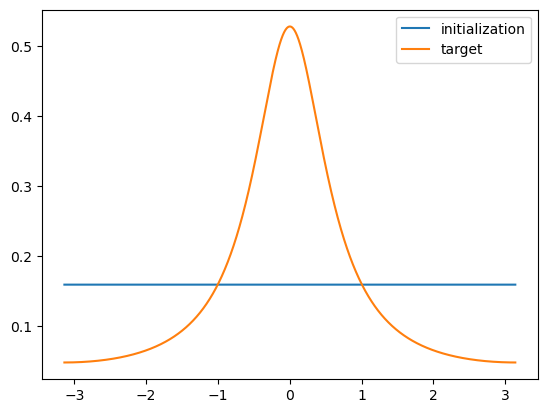

In [10]:
N = 2000

gamma_star = 10
gamma0 = 0

Theta = np.linspace(-np.pi, np.pi, N+1)
Theta = 0.5 * (Theta[1:]+Theta[:-1])

f0 = normalize(1 / (1 + gamma0 * np.cos(Theta/2)**2)) ## initialization
f_star = normalize(1 / (1 + gamma_star * np.sin(Theta/2)**2)) ## target

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(Theta, f0, label='initialization')
ax.plot(Theta, f_star, label='target')
plt.legend()
#ax.axis('equal')

In [353]:
def F(f, t):
    return - 0.5 * f * Laplacian((f_star / f)**2, h=2*np.pi/N) - 0.5 * Grad((f_star / f)**2, h=2*np.pi/N) * Grad(f, h=2*np.pi/N)

In [357]:
t = np.linspace(0, 2000*2**(-10), 1001)
f_list = odeint(F, f0, t)

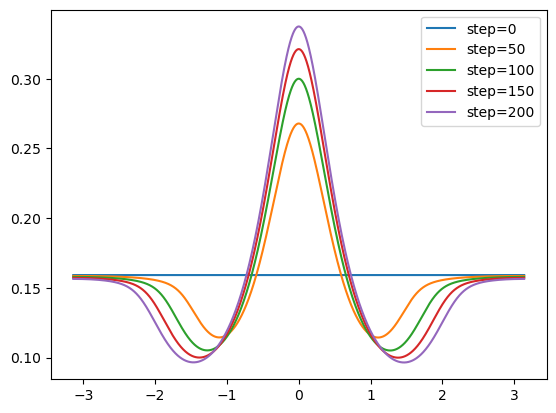

In [359]:
for i in range(0, 201, 50):
    plt.plot(Theta, f_list[i], label=f'step={i}')
plt.legend()

## ReLU activation 1D
The model is a SHL with ReLU activation taking inputs in 2d and with features and the circle

In [28]:
## Teacher model
activation = nn.ReLU() ## activation function
clipper = FeatureClipper(Normalization())

teacher_width = 10000
teacher = SHL(2, teacher_width, activation, bias=False, clipper=clipper)

gamma = 10 ## Parameter controling the shape of the target distribution

Theta = np.linspace(-np.pi, np.pi, teacher_width, endpoint=False)
teacher_init = torch.tensor([[np.cos(theta), np.sin(theta)] for theta in Theta], dtype=torch.float32)
teacher_init = teacher_init @ torch.tensor([[(1+gamma)**0.5, 0], [0, 1]], dtype=torch.float32)
teacher_init = teacher_init / torch.norm(teacher_init, 2, dim=-1, keepdim=True).expand_as(teacher_init)
Theta = circle_to_line(teacher_init.numpy())
Theta = 2*Theta

teacher_init = torch.tensor([[np.cos(theta), np.sin(theta)] for theta in Theta], dtype=torch.float32)
#rotation = torch.tensor([[0, -1], [1, 0]], dtype=torch.float32)
#teacher_init[:teacher_width//2] = teacher_init[:teacher_width//2] @ rotation

teacher.feature_model.weight = nn.Parameter(data=teacher_init) ## teacher feature distribution
teacher.outer.weight = nn.Parameter(data=torch.ones_like(teacher.outer.weight), requires_grad=False) ## teacher outer weight

teacher.clipper(teacher)
teacher.apply(freeze)

/var/folders/b5/pzc2mp2927v5m5s76m6ytq2w0000gp/T/ipykernel_40536/1263217457.py:67: RuntimeWarning: divide by zero encountered in divide
  return 2 * np.arctan( x[:,1] / (1+x[:,0]))


VarProModel(
  (feature_model): SHLFeatureModel(
    (activation): ReLU()
  )
  (outer): Linear(in_features=10000, out_features=1, bias=False)
)

/var/folders/b5/pzc2mp2927v5m5s76m6ytq2w0000gp/T/ipykernel_40536/1263217457.py:67: RuntimeWarning: divide by zero encountered in divide
  return 2 * np.arctan( x[:,1] / (1+x[:,0]))


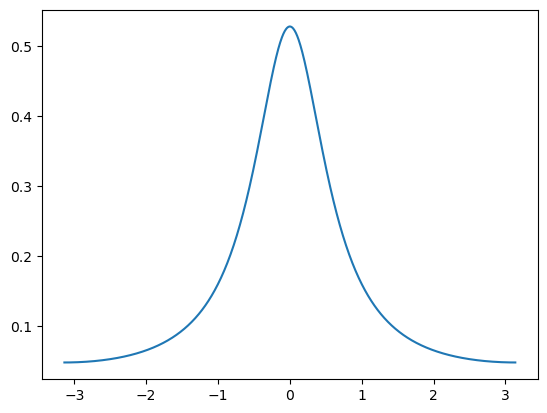

In [29]:
# plot of the teacher feature distribution
f_teacher = circle_to_line(teacher_init.numpy())
plt.plot(*gaussian_conv(f_teacher, scale=0.01))

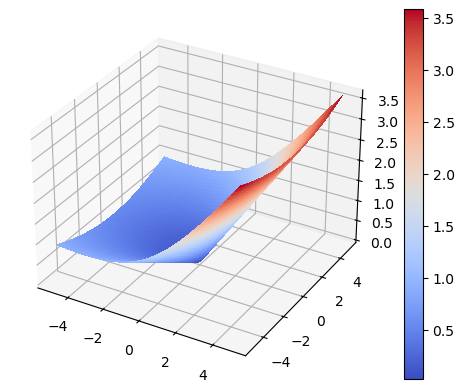

In [30]:
# plot of the teacher signal
_ = model_plot_2d(teacher)

In [31]:
# creating the dataset
N = 2048

inputs = torch.randn(N,2)
targets = teacher(inputs)
dataset = CustomDataset(inputs, targets)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))

In [163]:
## Student model
student_width = 256
clipper = FeatureClipper(Normalization())

init = torch.randn((student_width, 2), dtype=torch.float32)

student = SHL(2, student_width, activation, bias=False, clipper=clipper, VarProTraining=True)

student.feature_model.weight = nn.Parameter(data=init.clone().detach(), requires_grad=True)
student.outer.weight = nn.Parameter(data=torch.ones_like(student.outer.weight), requires_grad=False)
student.clipper(student)

In [164]:
## Training
lmbda = 1e-3
time_scale = 2**(-10)
lr = student_width * time_scale

# biased or unbiased loss
projection = ExactRidgeProjection(lmbda)
criterion = LeastSquareCriterion(lmbda, projection)
#projection = ExactRidgeProjectionUnbiased(lmbda)
#criterion = LeastSquareCriterionUnbiased(lmbda, projection)
                                   
optimizer = torch.optim.SGD([student.feature_model.weight], lr=lr)
#optimizer.add_param_group({'lr': 5*student_width*lmbda, 'params': student.outer.weight})

In [215]:
## one projection to set-up outer layer
inputs, targets = next(iter(train_loader))
projection(inputs, targets, student)

In [166]:
problem = LearningProblem(student, train_loader, optimizer, criterion)

In [167]:
problem.train(1000)

log10(loss) = -0.32: 100%|█████████████████| 1000/1000 [00:07<00:00, 142.80it/s]


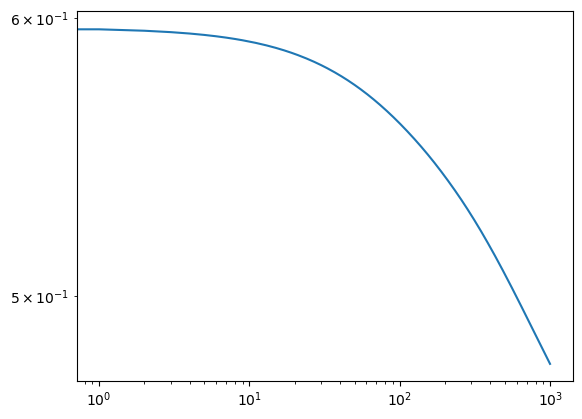

In [168]:
# training loss
plt.plot(problem.loss_list)
#plt.plot(problem_SHL.loss_list)
plt.yscale('log')
plt.xscale('log')

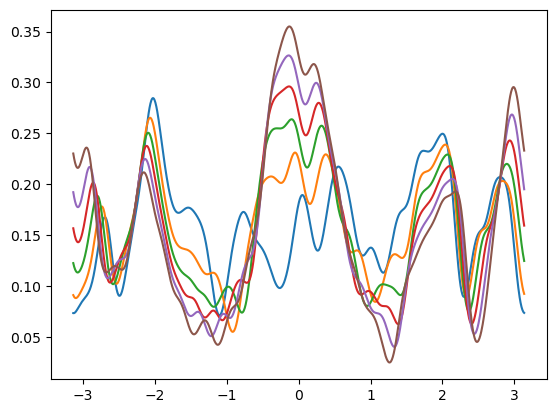

In [169]:
# plot of the learned feature distribution (diracs smoothed with a gaussian)
for i in np.arange(0, 1001, 200):
    w = problem.state_list[i]['feature_model.weight'].numpy()
    f = circle_to_line(w)

    #w_SHL = problem_SHL.state_list[i]['feature_model.0.weight'].numpy()
    #f_SHL = circle_to_line(w_SHL)
    
    plt.plot(*gaussian_conv(f, scale=0.1), label=f'step: {i}')
    #plt.plot(*gaussian_conv(f_SHL, scale=0.1), '--')
    #plt.plot(x, f_list[i], '--')
plt.legend()
#plt.yscale('log')

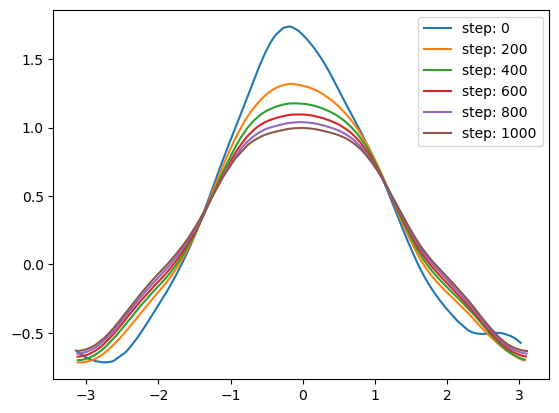

In [170]:
# plot of the outer layer weight (to check if positive and smooth)
for i in np.arange(0, 1001, 200):
    w = problem.state_list[i]['feature_model.weight'].numpy()
    f = circle_to_line(w)
    idx = np.argsort(f)
    u = problem.state_list[i]['outer.weight'].squeeze().numpy()

    #w_SHL = problem_SHL.state_list[i]['feature_model.0.weight'].numpy()
    #f_SHL = circle_to_line(w_SHL)
    #idx_SHL = np.argsort(f_SHL)
    #u_SHL = problem_SHL.state_list[i]['outer.weight'].squeeze().numpy()[idx_SHL]
    
    plt.plot(f[idx], u[idx], label=f'step: {i}')
    #plt.plot(u_SHL, '--')
plt.legend()

## Convolution in 1d

In [264]:
## Teacher model
activation = ActivationFunction(lambda t: torch.exp(-t**2)) ## activation function
clipper = SHLFeatureClipper(Normalization())
scale = 0.5

teacher_width = 10000
teacher = Convolution(2, teacher_width, activation, scale=scale, clipper=clipper)

gamma = 100

Theta = np.linspace(-np.pi, np.pi, teacher_width, endpoint=False)
teacher_init = torch.tensor([[np.cos(theta), np.sin(theta)] for theta in Theta], dtype=torch.float32)
teacher_init = teacher_init @ torch.tensor([[(1+gamma)**0.5, 0], [0, 1]], dtype=torch.float32)
teacher_init = teacher_init / torch.norm(teacher_init, 2, dim=-1, keepdim=True).expand_as(teacher_init)
Theta = circle_to_line(teacher_init.numpy())
Theta = 2*Theta
teacher_init = torch.tensor([[np.cos(theta), np.sin(theta)] for theta in Theta], dtype=torch.float32)
rotation = torch.tensor([[0, -1], [1, 0]], dtype=torch.float32)
teacher_init[:teacher_width//2] = teacher_init[:teacher_width//2] @ rotation

teacher.outer.weight = nn.Parameter(data=torch.ones_like(teacher.outer.weight), requires_grad=False)

teacher.feature_model.weight = nn.Parameter(data=teacher_init) ## teacher feature distribution
teacher.clipper(teacher)
teacher.apply(freeze)

/var/folders/b5/pzc2mp2927v5m5s76m6ytq2w0000gp/T/ipykernel_11175/3666372671.py:52: RuntimeWarning: divide by zero encountered in divide
  return 2 * np.arctan( x[:,1] / (1+x[:,0]))


VarProModel(
  (feature_model): ConvolutionFeatureModel(
    (activation): ActivationFunction()
  )
  (outer): Linear(in_features=10000, out_features=1, bias=False)
)

In [265]:
## Data
d = 1
N = 2048

inputs = torch.randn(N,2)
targets = teacher(inputs)
dataset = CustomDataset(inputs, targets)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))

/var/folders/b5/pzc2mp2927v5m5s76m6ytq2w0000gp/T/ipykernel_11175/3666372671.py:52: RuntimeWarning: divide by zero encountered in divide
  return 2 * np.arctan( x[:,1] / (1+x[:,0]))


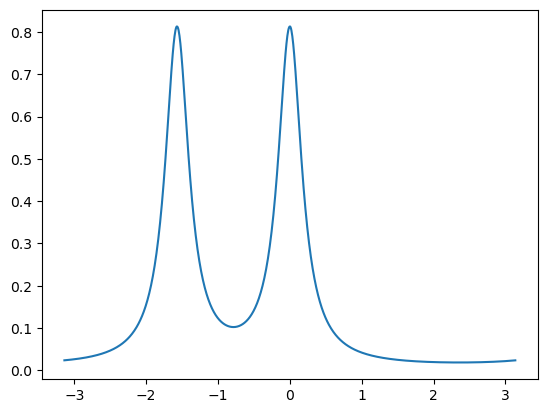

In [266]:
f_teacher = circle_to_line(teacher_init.numpy())
plt.plot(*gaussian_conv(f_teacher, scale=0.01))

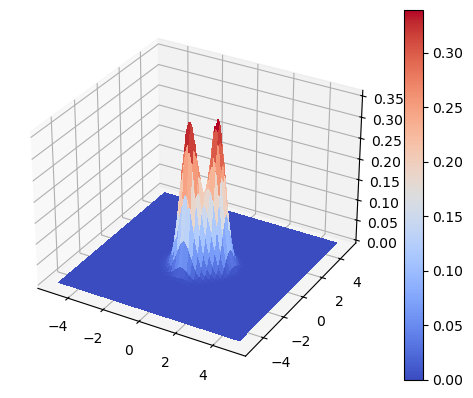

In [267]:
_ = model_plot_2d(teacher)

In [268]:
## Student model
student_width = 256

init = torch.randn((student_width, 2), dtype=torch.float32)

student = Convolution(2, student_width, activation, scale=scale, clipper=clipper, VarProTraining=True)
#student.to(torch.double)

student.feature_model.weight = nn.Parameter(data=init.clone().detach(), requires_grad=True)
student.outer.weight = nn.Parameter(data=torch.ones_like(student.outer.weight), requires_grad=False)
student.clipper(student)

In [269]:
## Training
lmbda = 1e-3
time_scale = 2**(-10)
lr = student_width * time_scale

projection = ExactRidgeProjection(lmbda)
criterion = LeastSquareCriterion(lmbda, projection)
#projection = ExactRidgeProjectionUnbiased(lmbda)
#criterion = LeastSquareCriterionUnbiased(lmbda, projection)
                                   
optimizer = torch.optim.SGD([student.feature_model.weight], lr=lr)
#optimizer.add_param_group({'lr': 5*student_width*lmbda, 'params': student.outer.weight})

In [270]:
## one projection to set-up outer layer
inputs, targets = next(iter(train_loader))
projection(inputs, targets, student)

In [271]:
problem = LearningProblem(student, train_loader, optimizer, criterion)

In [272]:
problem.train(2000)

log10(loss) = -0.25: 100%|██████████████████| 2000/2000 [00:20<00:00, 99.03it/s]


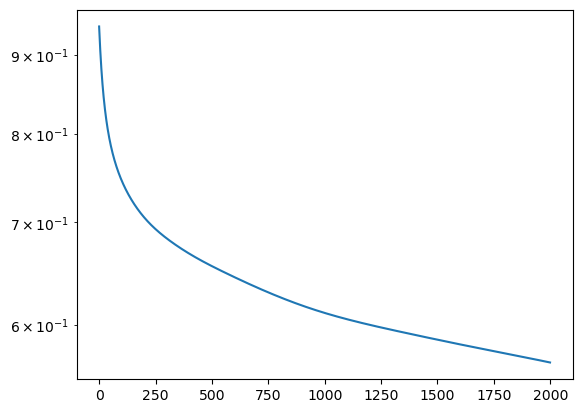

In [273]:
plt.plot(problem.loss_list)
#plt.plot(problem_SHL.loss_list)
plt.yscale('log')
#plt.xscale('log')

/var/folders/b5/pzc2mp2927v5m5s76m6ytq2w0000gp/T/ipykernel_11175/3666372671.py:52: RuntimeWarning: divide by zero encountered in divide
  return 2 * np.arctan( x[:,1] / (1+x[:,0]))


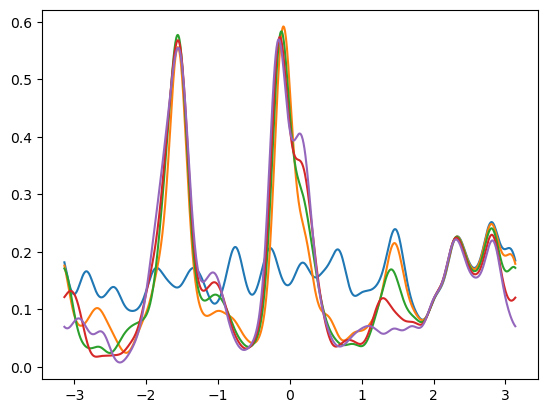

In [274]:
for i in np.arange(0, 2001, 500):
    w = problem.state_list[i]['feature_model.weight'].numpy()
    f = circle_to_line(w)

    #w_SHL = problem_SHL.state_list[i]['feature_model.0.weight'].numpy()
    #f_SHL = circle_to_line(w_SHL)
    
    plt.plot(*gaussian_conv(f, scale=0.1), label=f'step: {i}')
    #plt.plot(*gaussian_conv(f_SHL, scale=0.1), '--')
    #plt.plot(x, f_list[i], '--')
#plt.legend()
#plt.yscale('log')

/var/folders/b5/pzc2mp2927v5m5s76m6ytq2w0000gp/T/ipykernel_11175/3666372671.py:52: RuntimeWarning: divide by zero encountered in divide
  return 2 * np.arctan( x[:,1] / (1+x[:,0]))


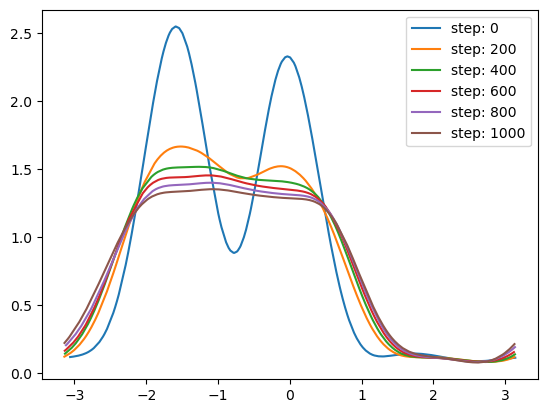

In [275]:
for i in np.arange(0, 1001, 200):
    w = problem.state_list[i]['feature_model.weight'].numpy()
    f = circle_to_line(w)
    idx = np.argsort(f)
    u = problem.state_list[i]['outer.weight'].squeeze().numpy()

    #w_SHL = problem_SHL.state_list[i]['feature_model.0.weight'].numpy()
    #f_SHL = circle_to_line(w_SHL)
    #idx_SHL = np.argsort(f_SHL)
    #u_SHL = problem_SHL.state_list[i]['outer.weight'].squeeze().numpy()[idx_SHL]
    
    plt.plot(f[idx], u[idx], label=f'step: {i}')
    #plt.plot(u_SHL, '--')
plt.legend()

## SHL with trigonometric activation 2d

In [290]:
## Teacher model
activation = ActivationFunction(torch.cos)

xlim = 3
clipper = FeatureClipper(PeriodicBoundaryCondition(x_min=-xlim, x_max=xlim))

teacher_width = 10000
teacher = SHL(2, teacher_width, activation, bias=False, clipper=clipper)

teacher_weight = 0.1 * torch.randn((teacher_width, 2), dtype=torch.float32)

#teacher_weight = xlim * (2 * torch.rand((teacher_width, 2), dtype=torch.float32) - 1)
#teacher_bias = np.pi * torch.rand(teacher_width, dtype=torch.float32)

teacher.feature_model.weight = nn.Parameter(data=teacher_weight) ## teacher feature distribution
#teacher.feature_model.bias = nn.Parameter(data=teacher_bias)

teacher.clipper(teacher)

teacher.outer.weight = nn.Parameter(data=torch.ones_like(teacher.outer.weight), requires_grad=False)

teacher.apply(freeze)

VarProModel(
  (feature_model): SHLFeatureModel(
    (activation): ActivationFunction()
  )
  (outer): Linear(in_features=10000, out_features=1, bias=False)
)

In [291]:
# data
N = 2048

inputs = torch.randn(N,2)
targets = teacher(inputs)
dataset = CustomDataset(inputs, targets)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))

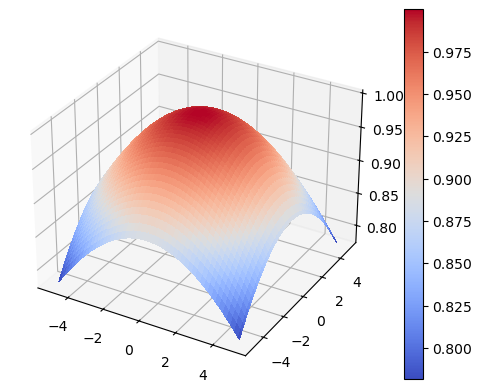

In [292]:
_ = model_plot_2d(teacher)

In [324]:
## Student model
#clipper = FeatureClipper(PeriodicBoundaryCondition(x_min=-xlim, x_max=xlim))
clipper = FeatureBiasClipper(PeriodicBoundaryCondition(x_min=-xlim, x_max=xlim),
                                PeriodicBoundaryCondition(x_min=-np.pi, x_max=np.pi))

student_width = 256

student = SHL(2, student_width, activation, bias=True, clipper=clipper, VarProTraining=True)


weight_init = xlim * (2 * torch.rand((student_width, 2), dtype=torch.float32) - 1)
bias_init = np.pi * (2*torch.rand(student_width, dtype=torch.float32)-1)

student.feature_model.weight = nn.Parameter(data=weight_init.clone().detach(), requires_grad=True)
student.feature_model.bias = nn.Parameter(data=bias_init.clone().detach(), requires_grad=True)

student.clipper(student)

In [306]:
### Training
lmbda = 1e-3
time_scale = 2**(-10)
lr = student_width * time_scale

# biased or unbiased loss
projection = ExactRidgeProjection(lmbda)
criterion = LeastSquareCriterion(lmbda, projection)
#projection = ExactRidgeProjectionUnbiased(lmbda) 
#criterion = LeastSquareCriterionUnbiased(lmbda, projection)
                                   
optimizer = torch.optim.SGD([student.feature_model.weight, student.feature_model.bias], lr=lr)

In [307]:
## one projection to set-up outer layer
inputs, targets = next(iter(train_loader))
projection(inputs, targets, student)

In [308]:
problem = LearningProblem(student, train_loader, optimizer, criterion)

In [313]:
problem.train(2000)

log10(loss) = -0.17: 100%|█████████████████| 2000/2000 [00:14<00:00, 136.36it/s]


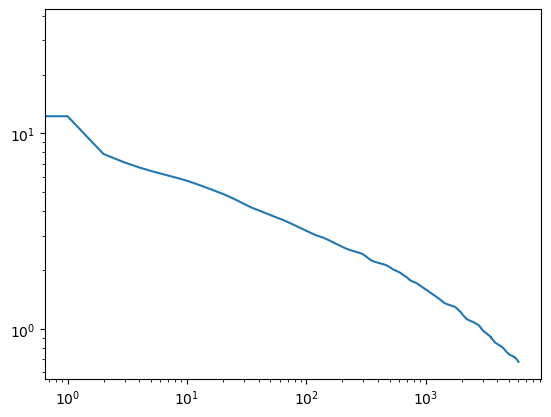

In [314]:
plt.plot(problem.loss_list)
#plt.plot(problem_SHL.loss_list)
plt.yscale('log')
plt.xscale('log')

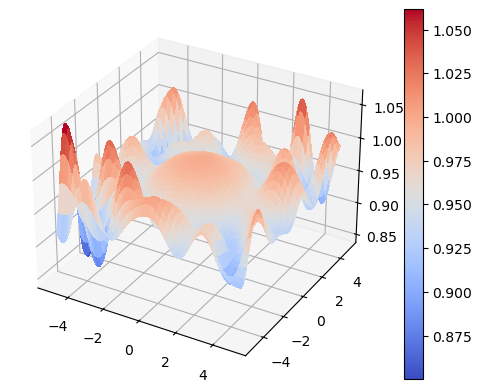

In [315]:
_ = model_plot_2d(student)

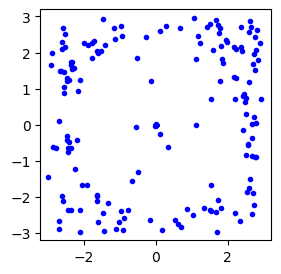

In [316]:
w_array = np.array([dico['feature_model.weight'].numpy() for dico in problem.state_list]) 

weight_animation_2d(w_array, name='SHL_2d_animation.mp4')

## Convolution 2d

In [329]:
## Teacher model
activation = ActivationFunction(lambda t: torch.exp(-t**2))
scale = 1

xlim = 3
clipper = FeatureClipper(PeriodicBoundaryCondition(x_min=-xlim, x_max=xlim))

teacher_width = 10000
teacher = Convolution(2, teacher_width, activation, scale, clipper=clipper)

teacher_weight = 0.01 * torch.randn((teacher_width, 2), dtype=torch.float32)

teacher.feature_model.weight = nn.Parameter(data=teacher_weight) ## teacher feature distribution
#teacher.feature_model.bias = nn.Parameter(data=teacher_bias)

teacher.clipper(teacher)

teacher.outer.weight = nn.Parameter(data=torch.ones_like(teacher.outer.weight), requires_grad=False)

teacher.apply(freeze)

VarProModel(
  (feature_model): ConvolutionFeatureModel(
    (activation): ActivationFunction()
  )
  (outer): Linear(in_features=10000, out_features=1, bias=False)
)

In [330]:
# data
N = 2048

inputs = torch.randn(N,2)
targets = teacher(inputs)
dataset = CustomDataset(inputs, targets)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))

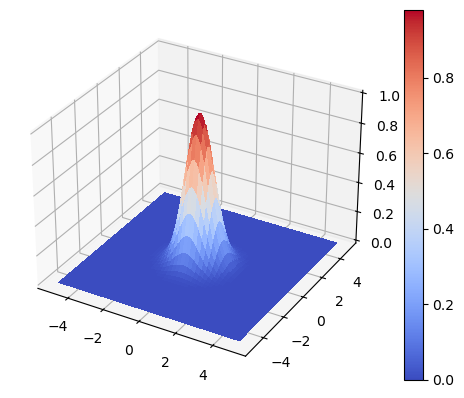

In [331]:
_ = model_plot_2d(teacher)

In [341]:
## Student model
student_width = 256

student = Convolution(2, student_width, activation, scale=scale, clipper=clipper, VarProTraining=True)

weight_init = xlim * (2 * torch.rand((student_width, 2), dtype=torch.float32) - 1)

student.feature_model.weight = nn.Parameter(data=weight_init.clone().detach(), requires_grad=True)

student.clipper(student)

In [342]:
### Training
lmbda = 1e-3
time_scale = 2**(-10)
lr = student_width * time_scale

# biased or unbiased loss
projection = ExactRidgeProjection(lmbda)
criterion = LeastSquareCriterion(lmbda, projection)
#projection = ExactRidgeProjectionUnbiased(lmbda) 
#criterion = LeastSquareCriterionUnbiased(lmbda, projection)
                                   
optimizer = torch.optim.SGD([student.feature_model.weight], lr=lr)

In [343]:
## one projection to set-up outer layer
inputs, targets = next(iter(train_loader))
projection(inputs, targets, student)

In [344]:
problem = LearningProblem(student, train_loader, optimizer, criterion)

In [345]:
problem.train(2000)

log10(loss) = -0.08: 100%|██████████████████| 2000/2000 [00:21<00:00, 95.22it/s]


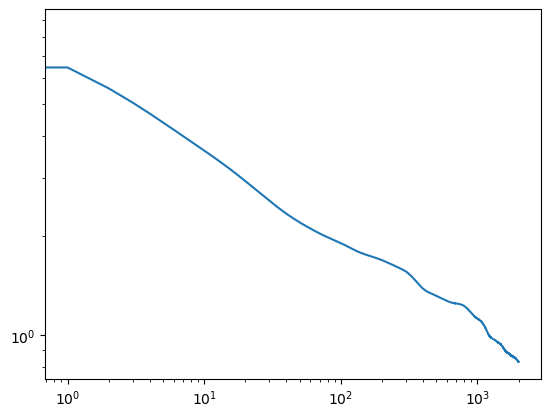

In [346]:
plt.plot(problem.loss_list)
#plt.plot(problem_SHL.loss_list)
plt.yscale('log')
plt.xscale('log')

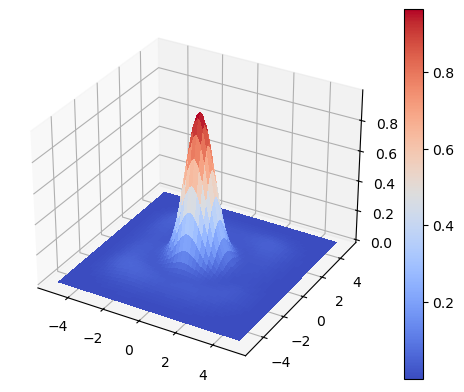

In [347]:
_ = model_plot_2d(student)

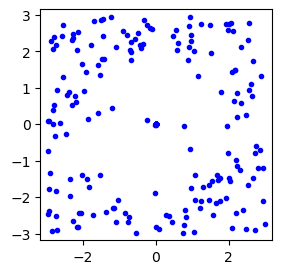

In [340]:
w_array = np.array([dico['feature_model.weight'].numpy() for dico in problem.state_list]) 

weight_animation_2d(w_array, name='Convolution_2d_animation.mp4')

## Other things

In [20]:
class TeacherCosFunction():
    def __call__(self, inputs):
        norm = inputs.norm(dim=1)
        cos = inputs[:,0] / norm
        return 0.5 * norm * cos

class TeacherGammaFunction():
    def __init__(self, gamma):
        self.gamma = gamma

    def __call__(self, inputs):
        rotated_inputs = inputs @ torch.tensor([[1, 0], [0, (1+self.gamma)**0.5]])
        norm = rotated_inputs.norm(dim=1)
        cos = rotated_inputs[:,0] / norm
        sin = rotated_inputs[:,1] / norm
        r1 = cos * torch.asinh(cos*gamma**0.5)
        r2 = sin * torch.asin(sin*(gamma/(1+gamma))**0.5)
        return norm * (r1+r2) / (np.pi*gamma**0.5)

class TeacherStepFunction():
    def __init__(self, alpha, eps):
        self.alpha = alpha
        self.eps = eps
        self.beta = (1-2*(np.pi-eps)*alpha) / (2*eps)
        #assert self.beta > 0

    def __call__(self, inputs):
        inputs_array = inputs.clone().detach().numpy()
        norm = np.linalg.norm(inputs_array, axis=1)
        cos = inputs_array[:,0] / norm
        sin = inputs_array[:,1] / norm
        theta = 2 * np.arctan(sin / (1+cos))
        
        res = ((theta > -0.5*np.pi-self.eps)*(theta < -0.5*np.pi+self.eps)) * (1+np.sin(theta+self.eps))
        res += ((theta > 0.5*np.pi-self.eps)*(theta < 0.5*np.pi+self.eps)) * (1-np.sin(theta-self.eps))
        res += ((theta > -0.5*np.pi+self.eps)*(theta < 0.5*np.pi-self.eps)) * (np.sin(theta+self.eps)-np.sin(theta-self.eps))
    
        return torch.tensor((2 * self.alpha + (self.beta-self.alpha) * res) * norm, dtype=torch.float32)

## Data
d = 1
N = 2048
gamma = 10

alpha = 0.2 * (1 / 6.28)
eps = 0.1

teacher_function = TeacherGammaFunction(gamma)

inputs = torch.randn(N,2)
#rotated_inputs = inputs @ torch.tensor([[0, -1], [1, 0]], dtype=torch.float32)
#targets = 0.5*(teacher_function(inputs) + teacher_function(rotated_inputs)).view((N, 1))
targets = teacher_function(inputs).view((N, 1))
dataset = CustomDataset(inputs, targets)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))

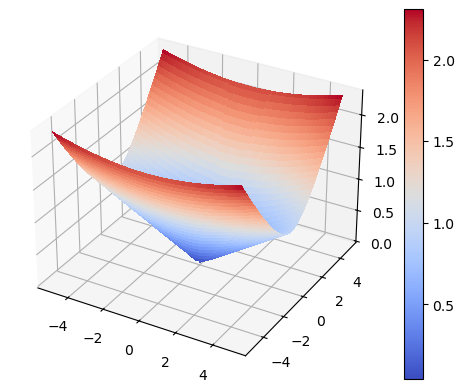

In [21]:
_ = model_plot_2d(teacher_function)

In [ ]:
class TeacherStudentProblem(LearningProblem):
    def __init__(self, student, teacher, inputs, optimizer, criterion):
        self.teacher = teacher
        self.dataset = CustomDataset(inputs, self.teacher(inputs).clone().detach())
        train_loader = torch.utils.data.DataLoader(self.dataset, batch_size=len(self.dataset))
        super().__init__(student, train_loader, optimizer, criterion)
        
        self.distance_dict = {}
        
    def compute_distance(self, distance, weight_ref=None, c_ref=None, name='teacher', distance_name=None, N_eval=100):
        
        weight_list = [dico['feature_model.0.weight'] for dico in self.state_list]
        
        if weight_ref is None:
            name = 'teacher'
            weight_ref = self.teacher.feature_model[0].weight.clone().detach()
            c_ref = self.teacher.outer.weight.detach().squeeze()
            c_ref.div_(c_ref.norm(p=1))
            
        distance_list, idx = compute_distance(distance, weight_list, weight_ref, c_ref=c_ref, N_eval=N_eval)
        step = len(self.loss_list) // (len(self.state_list)-1)

        self.distance_dict[name] = {'distance_name': distance_name, 'distance_list': distance_list, 'idx': step*idx}